In [7]:
import glob, h5py, math, time, os, json
from scipy.stats import norm, expon, chi2, uniform, chisquare
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

In [42]:
folders = {
    'h_2_ref': './out/h_2_NR50000_NB10000_NS0_M10000_lam1e-06_iter1000000/tvalues_flksigma3.7.h5',
    'h_2_SIG-5-100': './out/h_2_SIG-5_NR50000_NB10000_NS100_M10000_lam1e-06_iter1000000/tvalues_flksigma3.7.h5',
    'h_2_SIG-5-400': './out/h_2_SIG-5_NR50000_NB10000_NS400_M10000_lam1e-06_iter1000000/tvalues_flksigma3.7.h5',
    'h_2_SIG-6-100': './out/h_2_SIG-6_NR50000_NB10000_NS100_M10000_lam1e-06_iter1000000/tvalues_flksigma3.7.h5',
    'h_2_SIG-6-400': './out/h_2_SIG-6_NR50000_NB10000_NS400_M10000_lam1e-06_iter1000000/tvalues_flksigma3.7.h5',
    'h_2_SIG-6-1000': './out/h_2_SIG-6_NR50000_NB10000_NS1000_M10000_lam1e-06_iter1000000/tvalues_flksigma3.7.h5',
    
    'r_2_ref': './out/r_2_NR50000_NB10000_NS0_M10000_lam1e-06_iter1000000/tvalues_flksigma4.0.h5',
    'r_2_SIG-5-100': './out/r_2_SIG-5_NR50000_NB10000_NS100_M10000_lam1e-06_iter1000000/tvalues_flksigma4.0.h5',
    'r_2_SIG-5-400': './out/r_2_SIG-5_NR50000_NB10000_NS400_M10000_lam1e-06_iter1000000/tvalues_flksigma4.0.h5',
    'r_2_SIG-6-100': './out/r_2_SIG-6_NR50000_NB10000_NS100_M10000_lam1e-06_iter1000000/tvalues_flksigma4.0.h5',
    'r_2_SIG-6-400': './out/r_2_SIG-6_NR50000_NB10000_NS400_M10000_lam1e-06_iter1000000/tvalues_flksigma4.0.h5',
    'r_2_SIG-6-1000': './out/r_2_SIG-6_NR50000_NB10000_NS1000_M10000_lam1e-06_iter1000000/tvalues_flksigma4.0.h5',
    
    'h_4_ref': './out/h_4_SIG_NR50000_NB10000_NS0_M10000_lam1e-06_iter1000000/tvalues_flksigma4.3.h5',
    'h_4_SIG-5-100': './out/h_4_SIG-5_NR50000_NB10000_NS100_M10000_lam1e-06_iter1000000/tvalues_flksigma4.3.h5',
    'h_4_SIG-6-100': './out/h_4_SIG-6_NR50000_NB10000_NS100_M10000_lam1e-06_iter1000000/tvalues_flksigma4.3.h5',
    'h_4_SIG-6-400': './out/h_4_SIG-6_NR50000_NB10000_NS400_M10000_lam1e-06_iter1000000/tvalues_flksigma4.3.h5',
    'h_4_SIG-6-1000': './out/h_4_SIG-6_NR50000_NB10000_NS1000_M10000_lam1e-06_iter1000000/tvalues_flksigma4.3.h5',
    
    'r_4_ref': './out/r_4_NR50000_NB10000_NS0_M10000_lam1e-06_iter1000000/tvalues_flksigma4.7.h5',
    'r_4_SIG-5-100':'./out/r_4_SIG-5_NR50000_NB10000_NS100_M10000_lam1e-06_iter1000000/tvalues_flksigma4.7.h5',
    'r_4_SIG-6-100':'./out/r_4_SIG-6_NR50000_NB10000_NS100_M10000_lam1e-06_iter1000000/tvalues_flksigma4.7.h5',
    'r_4_SIG-6-400':'./out/r_4_SIG-6_NR50000_NB10000_NS400_M10000_lam1e-06_iter1000000/tvalues_flksigma4.7.h5',
    'r_4_SIG-6-1000':'./out/r_4_SIG-6_NR50000_NB10000_NS1000_M10000_lam1e-06_iter1000000/tvalues_flksigma4.7.h5',
}

In [43]:
def Z_score_chi2(t,df):
    sf = chi2.sf(t, df)
    Z  = -norm.ppf(sf)
    return Z

def Z_score_norm(t,mu, std):
    sf = norm.sf(t, mu, std)
    Z  = -norm.ppf(sf)
    return Z

def plot_1distribution(t, df, xmin=0, xmax=300, nbins=10, save=False, ymax=None, output_path='', save_name='', label=''):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!). 
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    Z_obs     = norm.ppf(chi2.cdf(np.median(t), df))
    t_obs_err = 1.2533*np.std(t)*1./np.sqrt(t.shape[0])
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t)+t_obs_err, df))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t)-t_obs_err, df))
    label  = 'sample %s\nsize: %i \nmedian: %s, std: %s\n'%(label, t.shape[0], str(np.around(np.median(t), 2)),str(np.around(np.std(t), 2)))
    label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    binswidth = (xmax-xmin)*1./nbins
    h = plt.hist(t, weights=np.ones_like(t)*1./(t.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=14) 
    plt.legend(prop=font, frameon=False)
    plt.xlabel('t', fontsize=18, fontname="serif")
    plt.ylabel('Probability', fontsize=18, fontname="serif")
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if ymax !=None:
        plt.ylim(0., ymax)
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_distribution.pdf')
            print('saved at %s'%(output_path+ save_name+'_distribution.pdf'))
    plt.show()
    plt.close(fig)
    return

def plot_2distribution(t1, t2, df, xmin=0, xmax=300, ymax=None, nbins=10, save=False, output_path='', label1='1', label2='2', save_name='', print_Zscore=True):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!).
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    binswidth = (xmax-xmin)*1./nbins
    # t1
    Z_obs     = Z_score_chi2(np.median(t1), df)
    t_obs_err = 1.2533*np.std(t1)*1./np.sqrt(t1.shape[0])
    Z_obs_p   = Z_score_chi2(np.median(t1)+t_obs_err, df)
    Z_obs_m   = Z_score_chi2(np.median(t1)-t_obs_err, df)
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label1, t1.shape[0], str(np.around(np.median(t1), 2)),str(np.around(np.std(t1), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    
    h = plt.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t1.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h[0])
    # t2
    Z_obs     = Z_score_chi2(np.median(t2), df)
    t_obs_err = 1.2533*np.std(t2)*1./np.sqrt(t2.shape[0])
    Z_obs_p   = Z_score_chi2(np.median(t2)+t_obs_err, df)
    Z_obs_m   = Z_score_chi2(np.median(t2)-t_obs_err, df)
    t_empirical = np.sum(1.*(t1>np.mean(t2)))*1./t1.shape[0]
    empirical_lim = '='
    if t_empirical==0:
        empirical_lim='>'
        t_empirical = 1./t1.shape[0]
    t_empirical_err = t_empirical*np.sqrt(1./np.sum(1.*(t1>np.mean(t2))+1./t1.shape[0]))
    Z_empirical = norm.ppf(1-t_empirical)
    Z_empirical_m = norm.ppf(1-(t_empirical+t_empirical_err))
    Z_empirical_p = norm.ppf(1-(t_empirical-t_empirical_err))
                                          
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label2, t2.shape[0], str(np.around(np.median(t2), 2)),str(np.around(np.std(t2), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s) \n'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        label += 'empirical Z %s %s (+%s/-%s)'%(empirical_lim, str(np.around(Z_empirical, 2)), str(np.around(Z_empirical_p-Z_empirical, 2)), str(np.around(Z_empirical-Z_empirical_m, 2)))
    h = plt.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), color='#8dd3c7', ec='seagreen',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t2.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='seagreen', marker='o', ls='')
    max2 = np.max(h[0])
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=20) #weight='bold', style='normal', 
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    plt.ylim(0., 1.2*np.maximum(max1, max2))#np.max(chi2.pdf(x, df))*1.3)
    if ymax !=None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_2distribution.pdf')
    plt.show()
    plt.close()
    return [Z_obs, Z_obs_p, Z_obs_m], [Z_empirical, Z_empirical_p, Z_empirical_m]

def Plot_Percentiles_ref(tvalues_check, dof, patience=1, title='', wc=None, ymax=300, ymin=0, save=False, output_path=''):
    '''
    The funcion creates the plot of the evolution in the epochs of the [2.5%, 25%, 50%, 75%, 97.5%] quantiles of the toy sample distribution.
    The percentile lines for the target chi2 distribution (dof required!) are shown as a reference.
    patience: interval between two check points (epochs).
    tvalues_check: array of t=-2*loss, shape = (N_toys, N_check_points)
    '''
    colors = [
    'seagreen',
    'mediumseagreen',
    'lightseagreen',
    '#2c7fb8',
    'midnightblue',
    ]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    epochs_check = []
    nr_check_points = tvalues_check.shape[1]
    for i in range(nr_check_points):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
    
    fig=plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    quantiles=[2.5, 25, 50, 75, 97.5]
    percentiles=np.array([])
    plt.xlabel('Training Epochs', fontsize=16, fontname="serif")
    plt.ylabel('t', fontsize=16, fontname="serif")
    plt.ylim(ymin, ymax)
    if wc != None:
        plt.title('Weight Clipping = '+wc, fontsize=16,  fontname="serif")
    for i in range(tvalues_check.shape[1]):
        percentiles_i = np.percentile(tvalues_check[:, i], quantiles)
        percentiles_i = np.expand_dims(percentiles_i, axis=1)
        if not i:
            percentiles = percentiles_i.T
        else:
            percentiles = np.concatenate((percentiles, percentiles_i.T))
    legend=[]
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, percentiles[:, j], marker='.', linewidth=3, color=colors[j])
        legend.append(str(quantiles[j])+' % quantile')
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, chi2.ppf(quantiles[j]/100., df=dof, loc=0, scale=1)*np.ones_like(epochs_check),
                color=colors[j], ls='--', linewidth=1)
        #print( chi2.ppf(quantiles[j]/100., df=dof, loc=0, scale=1))
        if j==0:
            legend.append("Target "+r"$\chi^2(dof=$"+str(dof)+")")
    font = font_manager.FontProperties(family='serif', size=16)         
    plt.legend(legend, prop=font)
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            fig.savefig(output_path+title+'_PlotPercentiles.pdf')
    plt.show()
    plt.close(fig)
    return

In [44]:
tests = {}
for k in  list(folders.keys()):
    f = h5py.File(folders[k], 'r')
    flk_sigma = folders[k].split('flksigma')[-1].replace('.h5', '')
    tests[k] = np.array(f[flk_sigma])
    f.close()

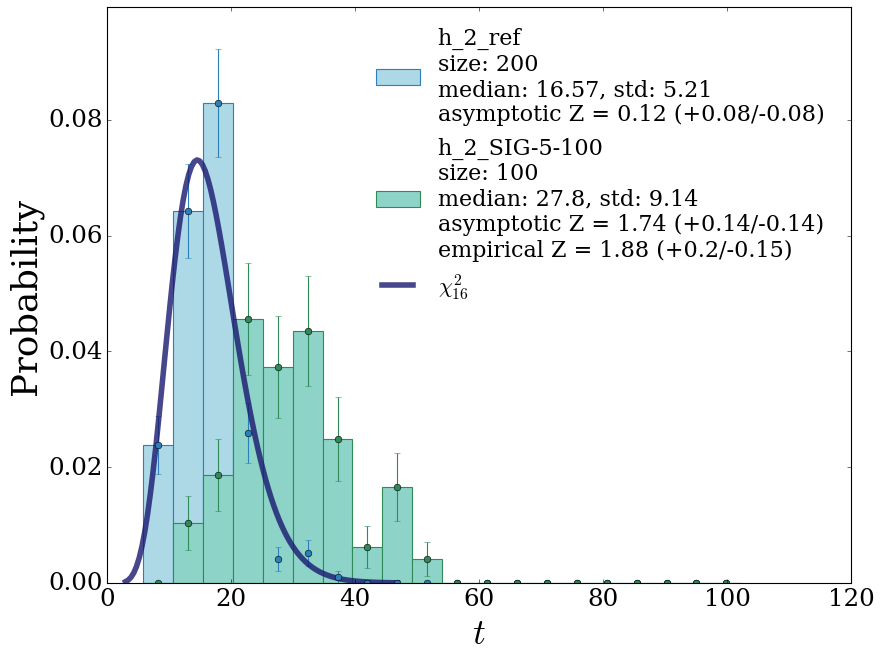

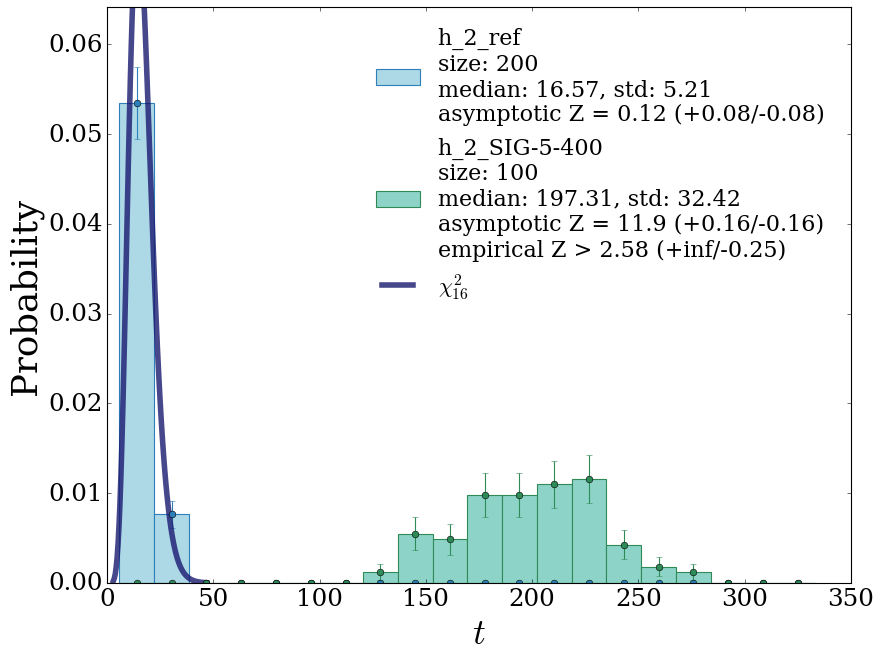

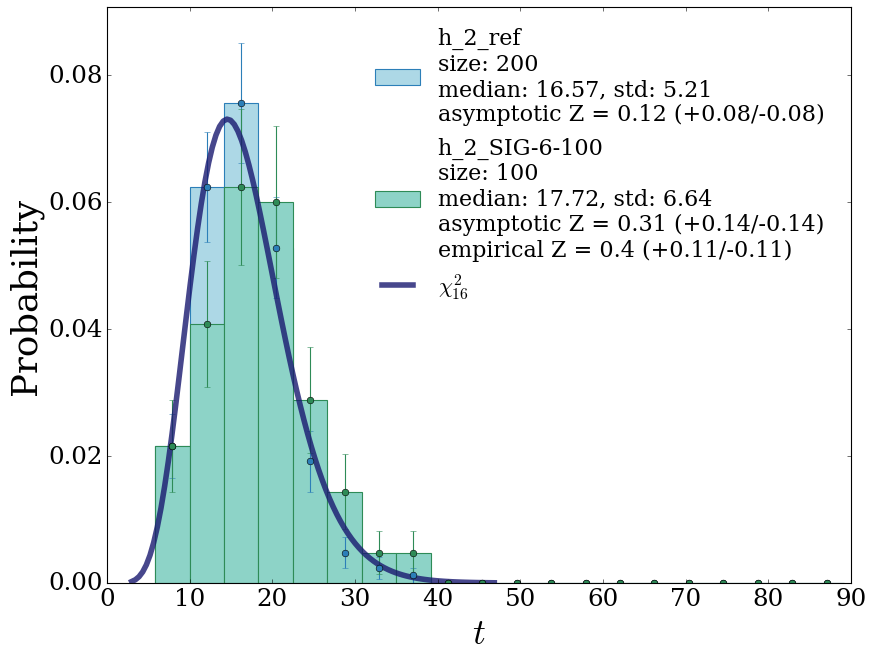

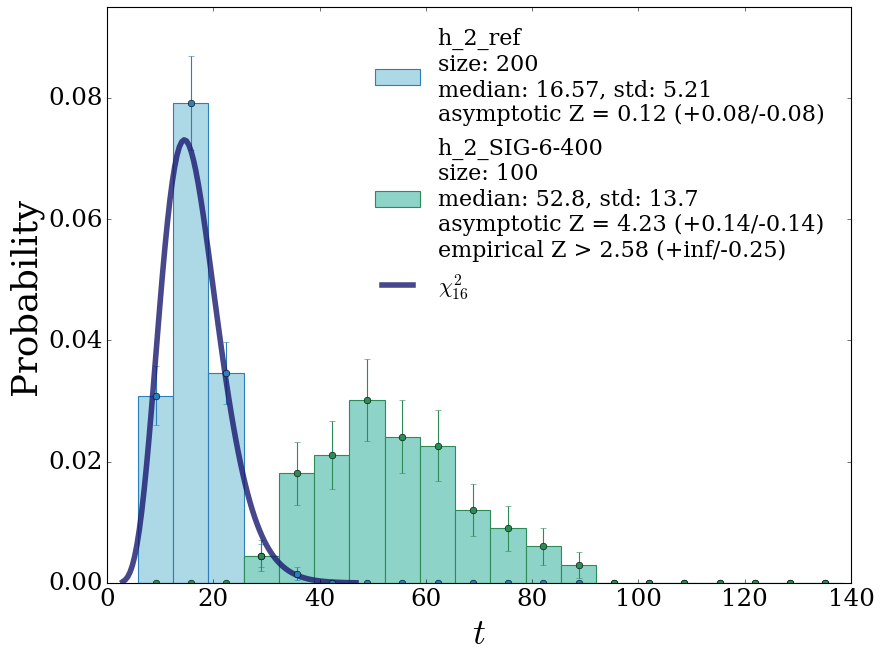

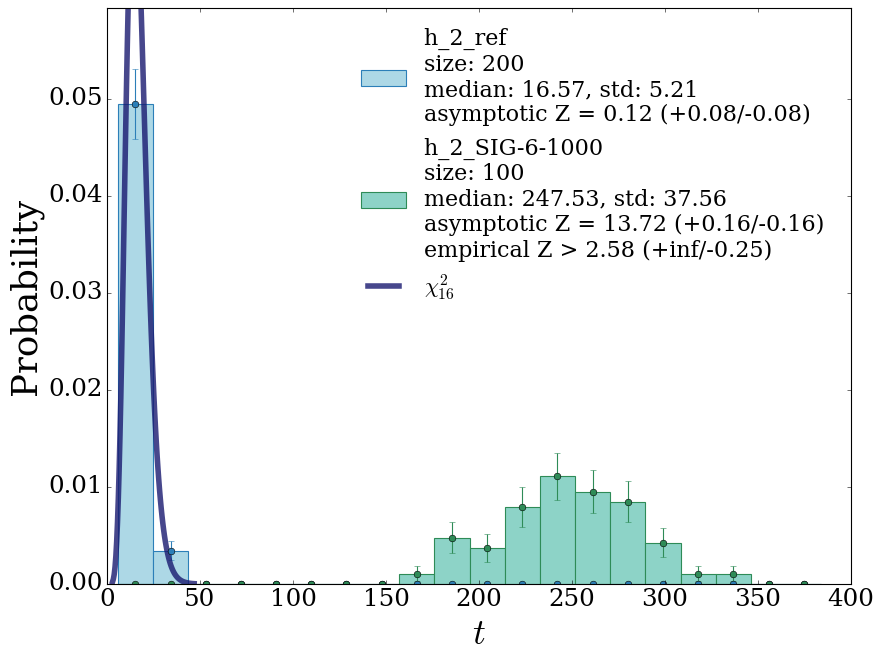

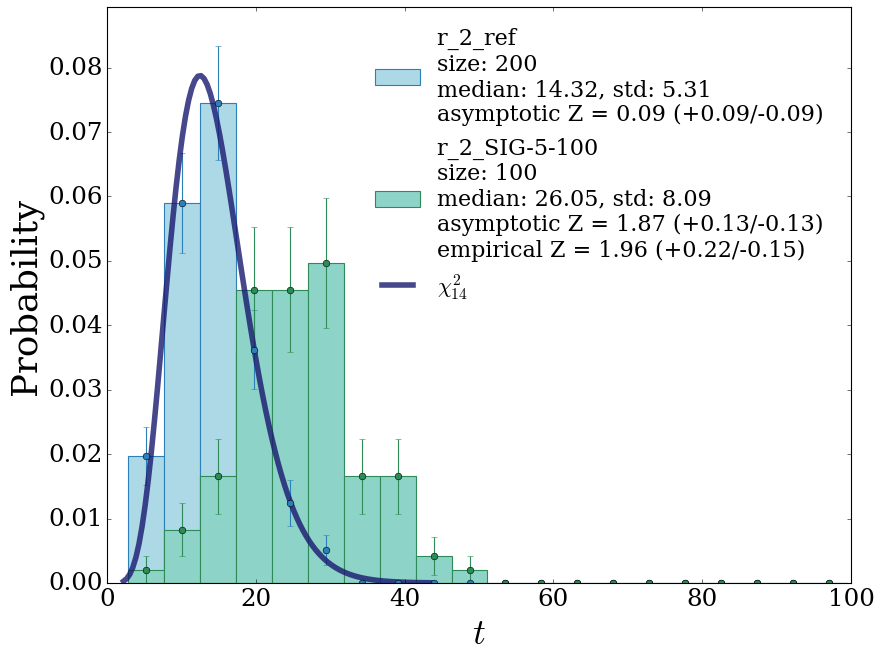

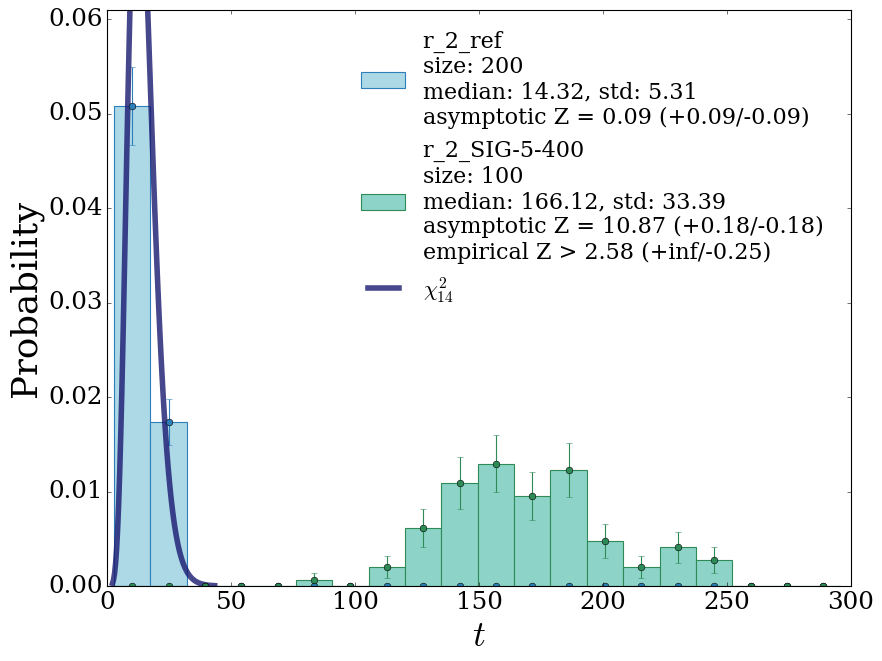

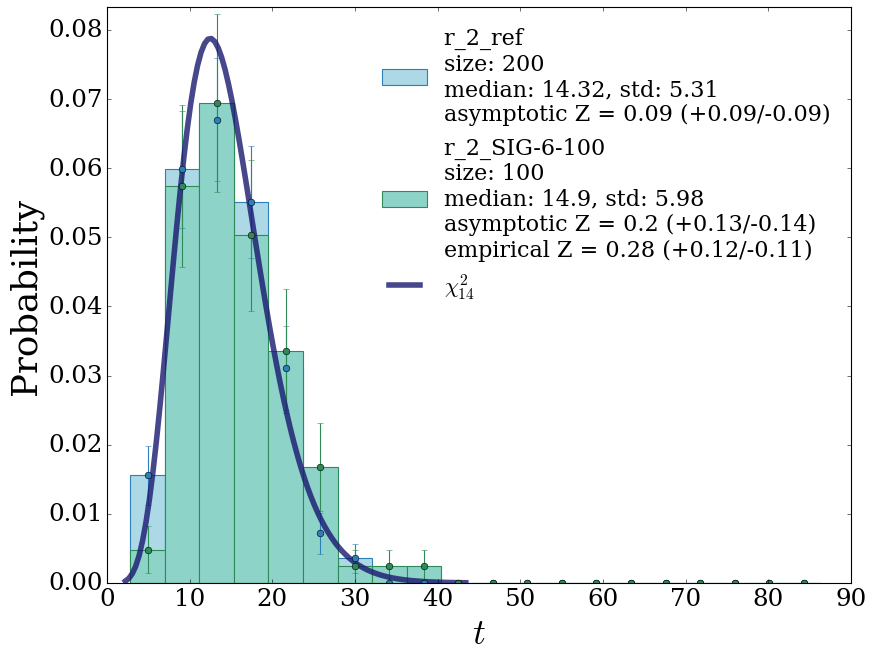

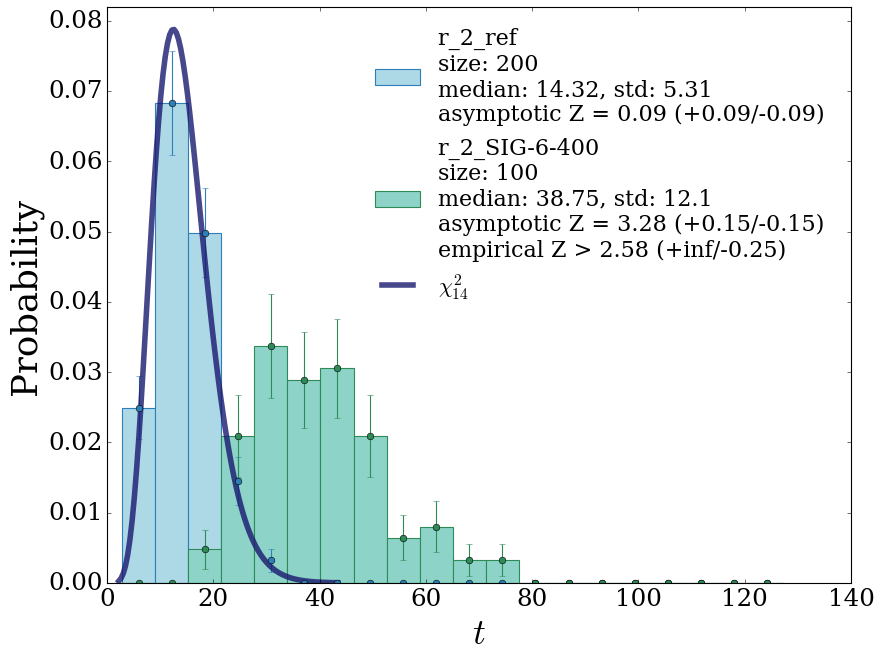

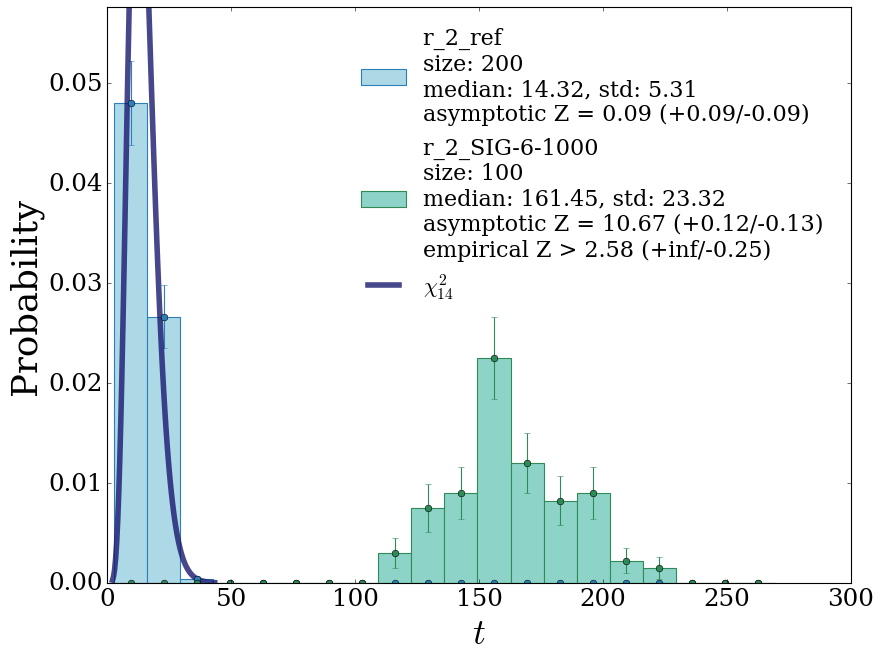

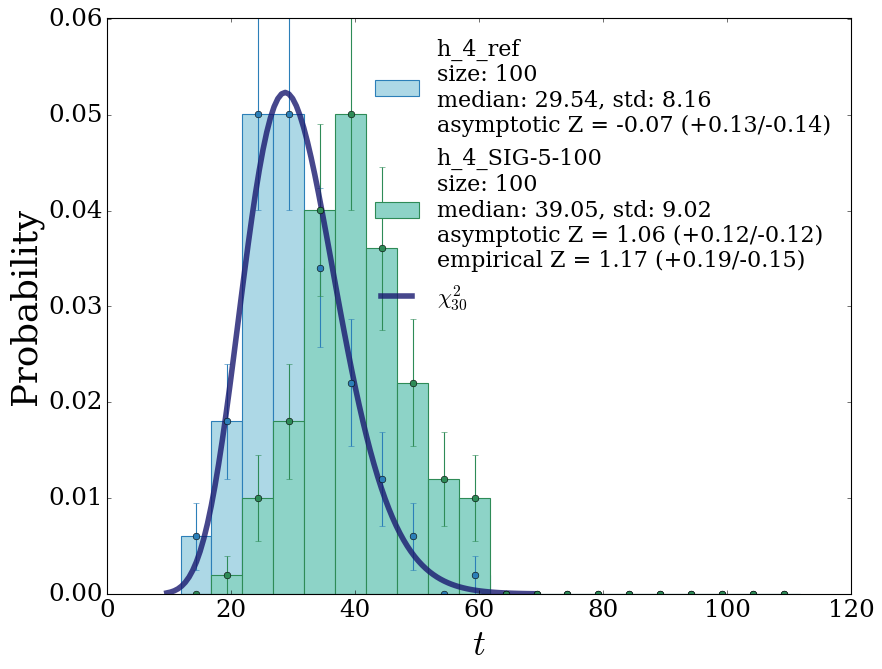

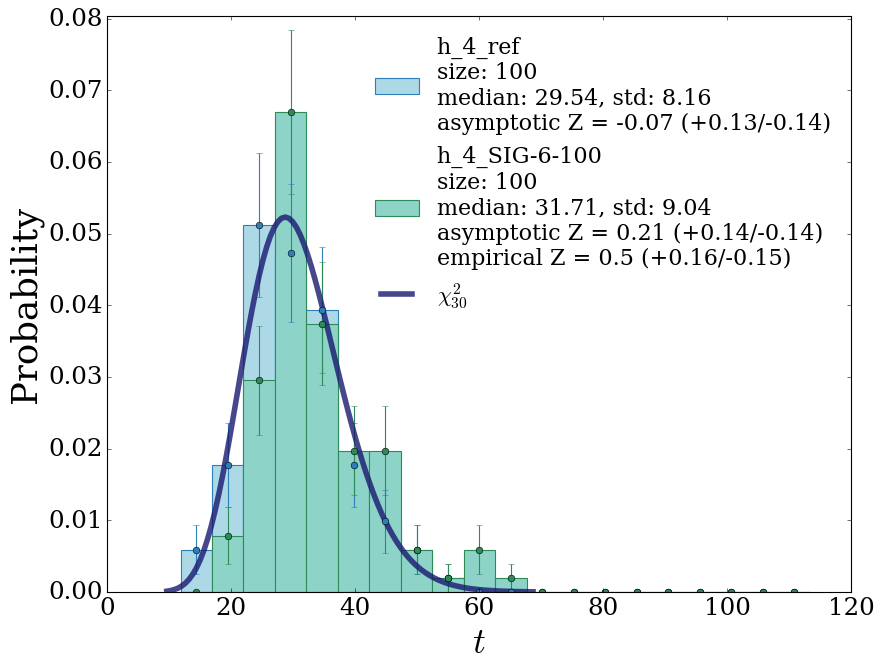

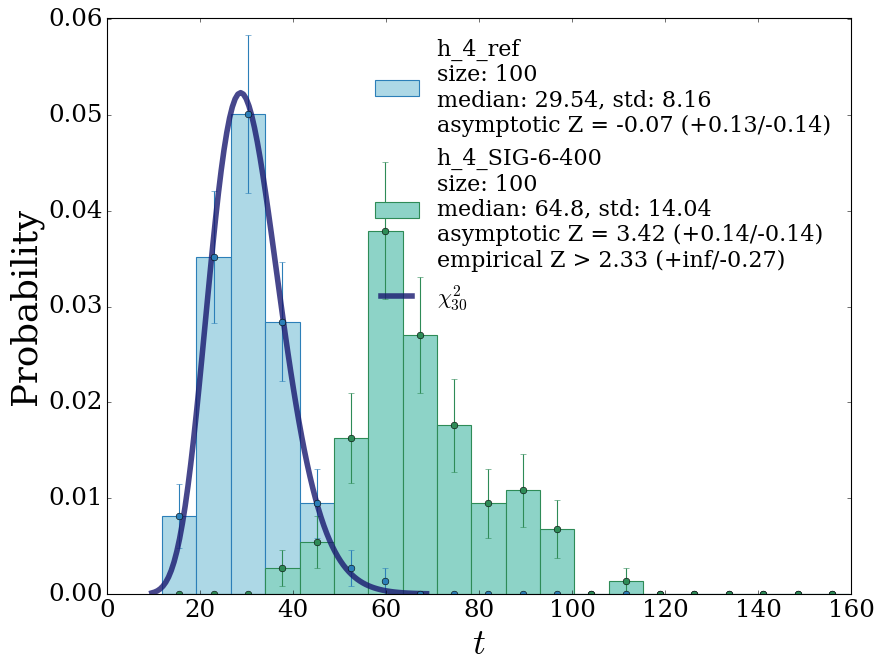

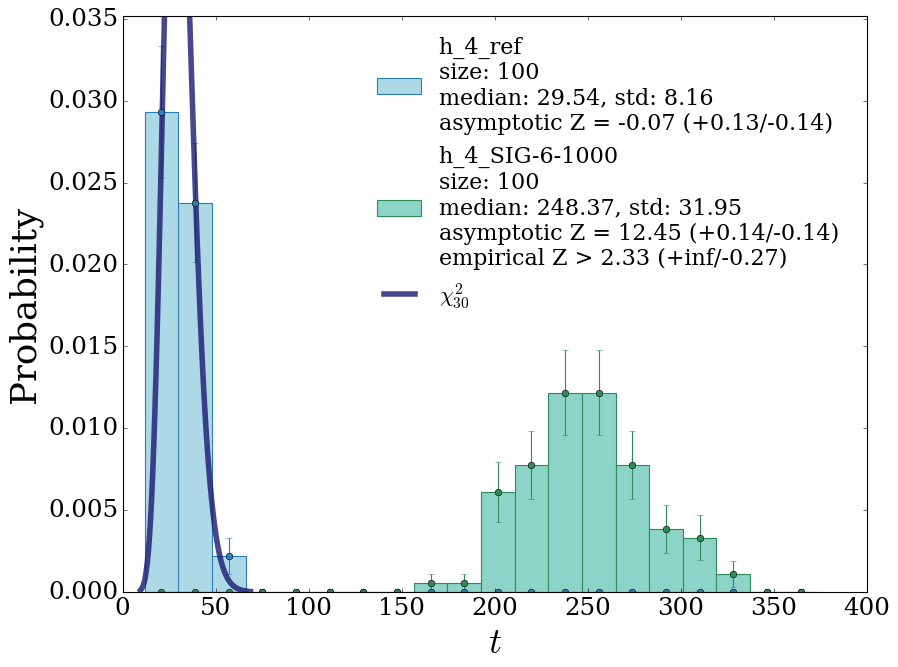

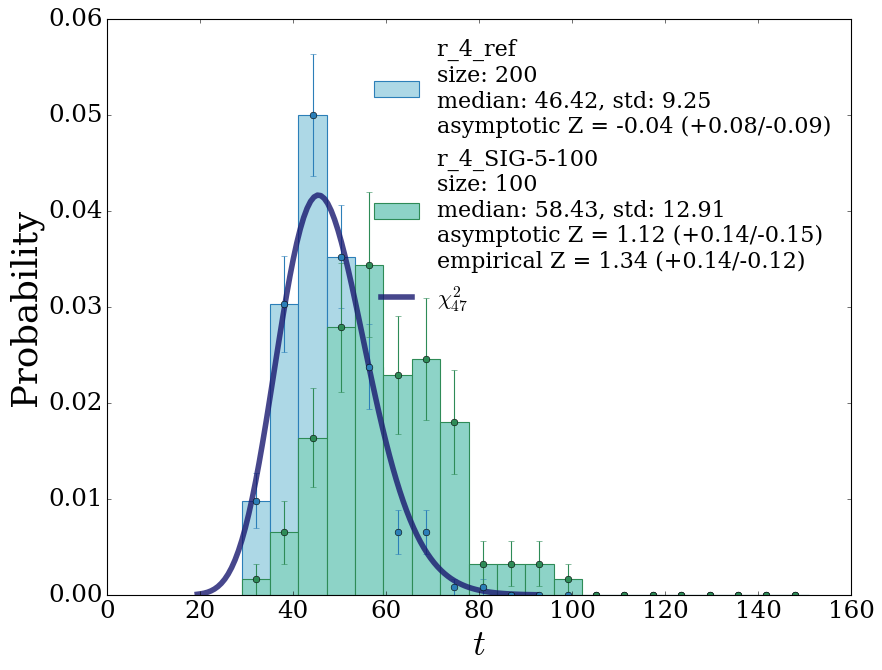

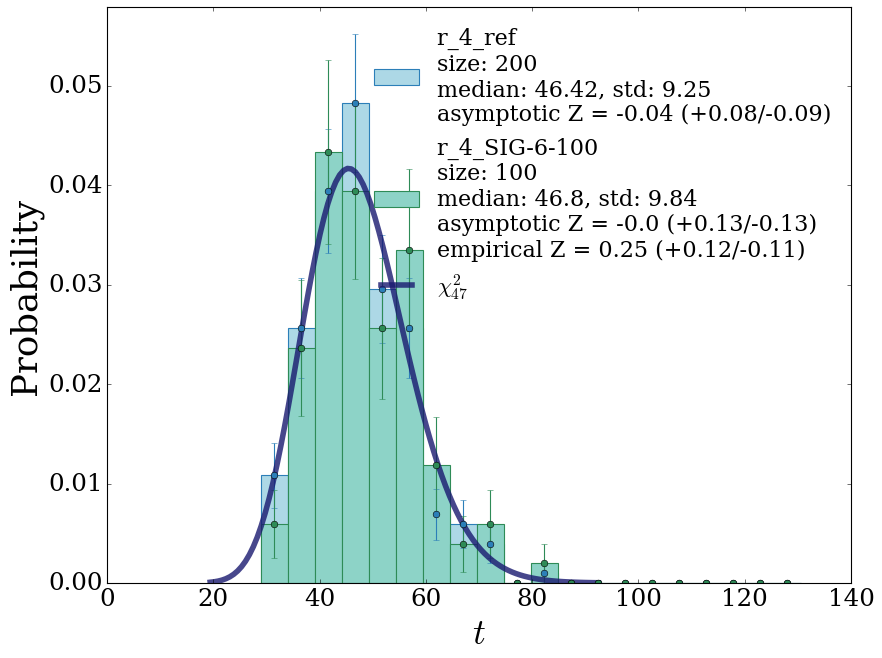

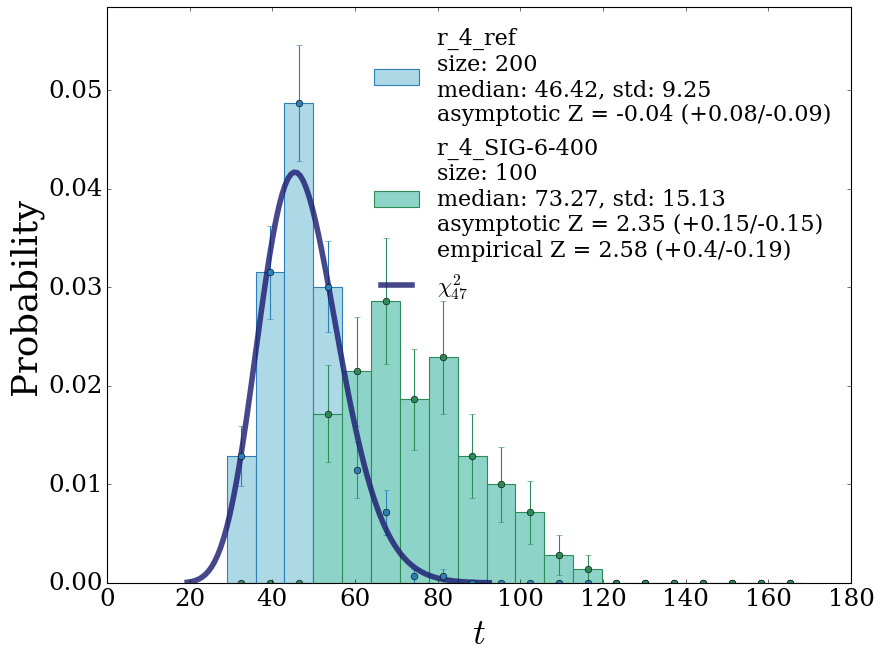

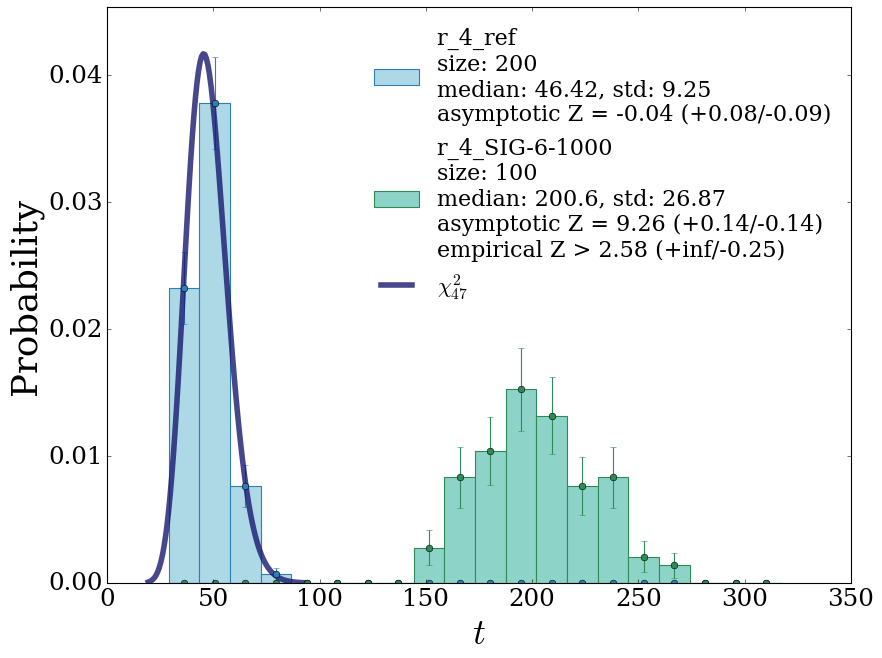

In [45]:

for key in list(tests.keys()):
    if 'ref' in key: continue
    key_ref = key.split('SIG')[0]+'ref'
    t1 = tests[key_ref]
    t2 = tests[key]
    df = np.mean(t1)
    xmax = np.max(t2)+50
    xmin = np.min(t1)
    plot_2distribution(t1, t2, df, xmin=xmin, xmax=xmax, ymax=None, nbins=20, 
                   save=False, output_path='', label1=key_ref, label2=key, save_name='', print_Zscore=True)


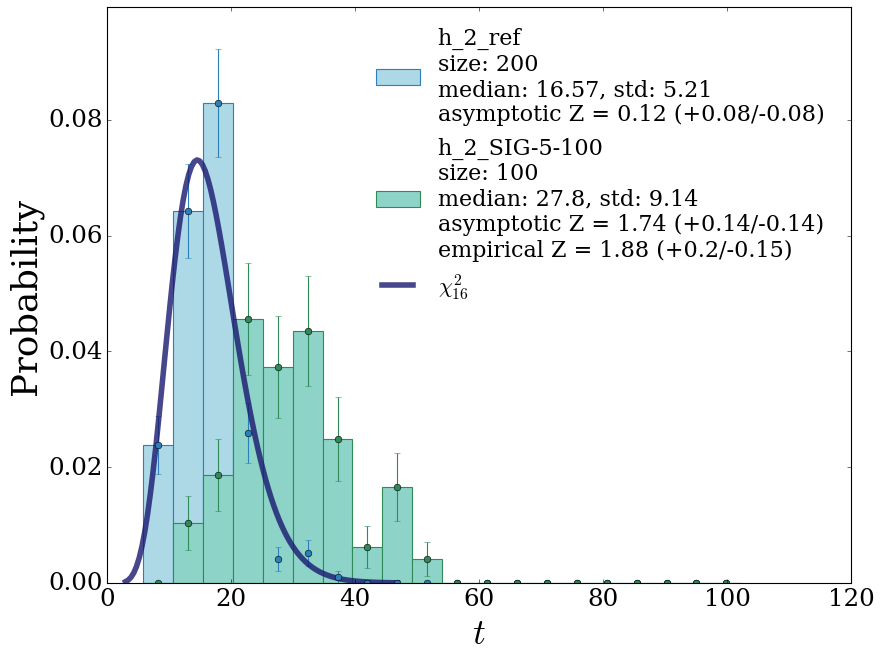

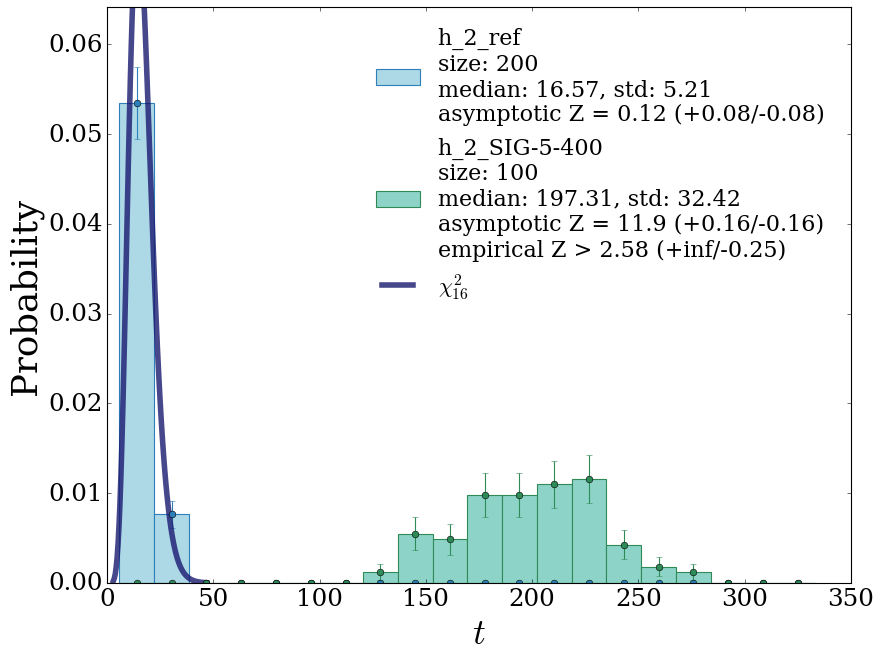

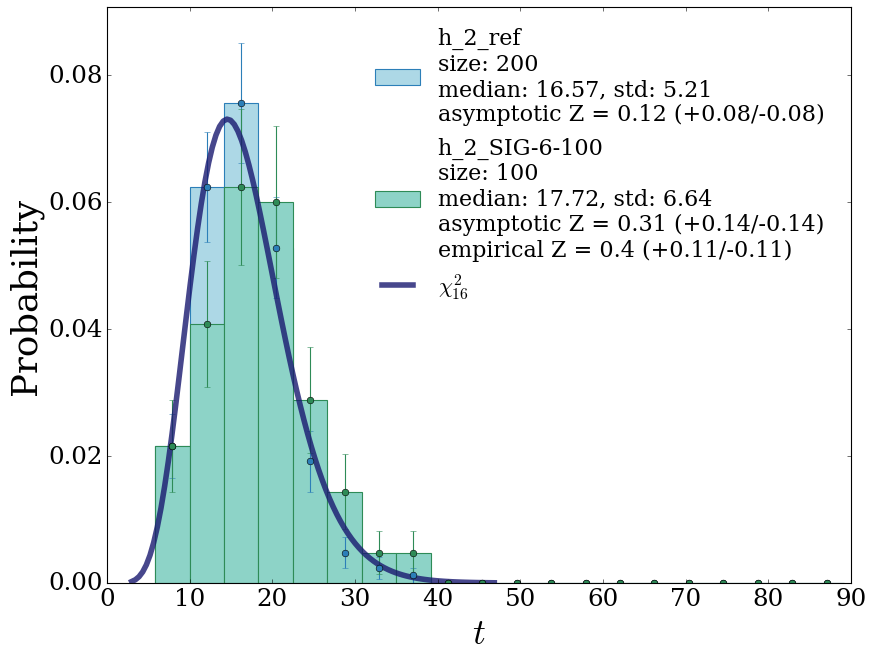

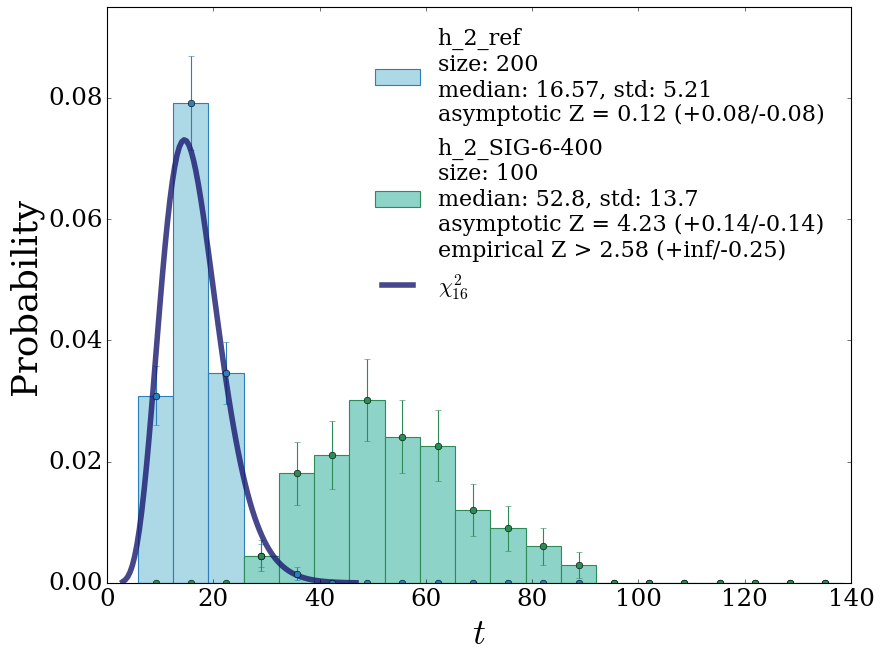

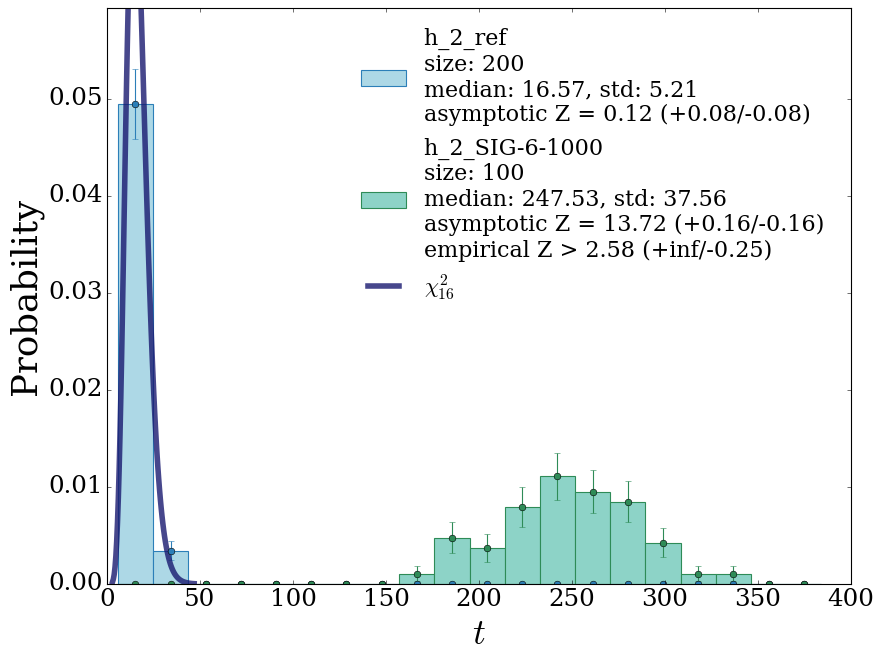

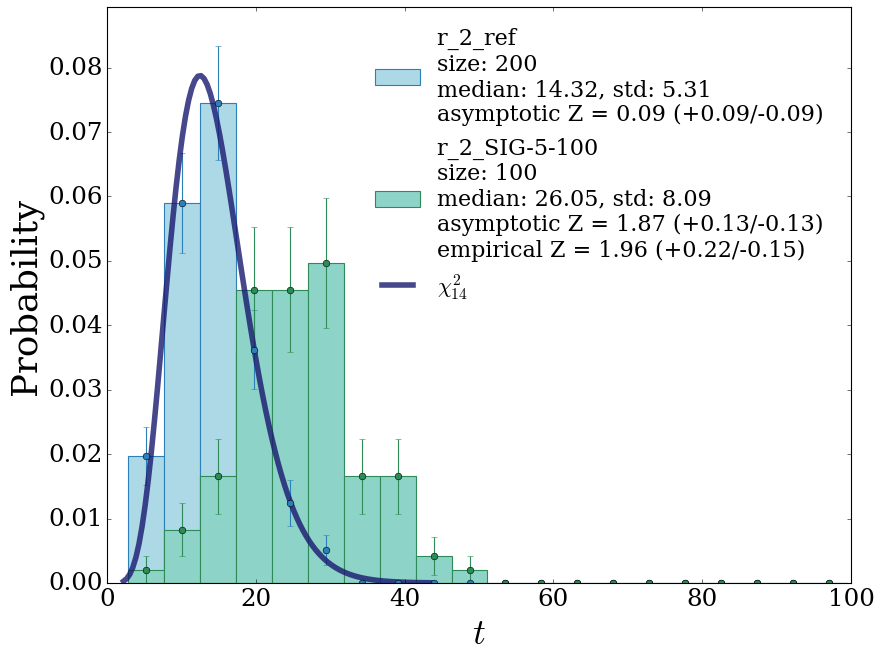

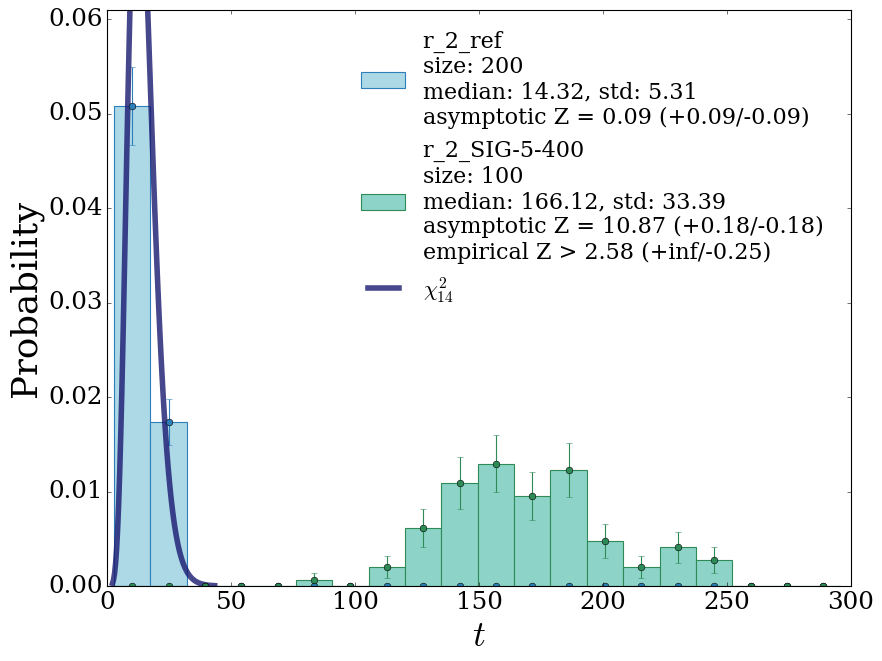

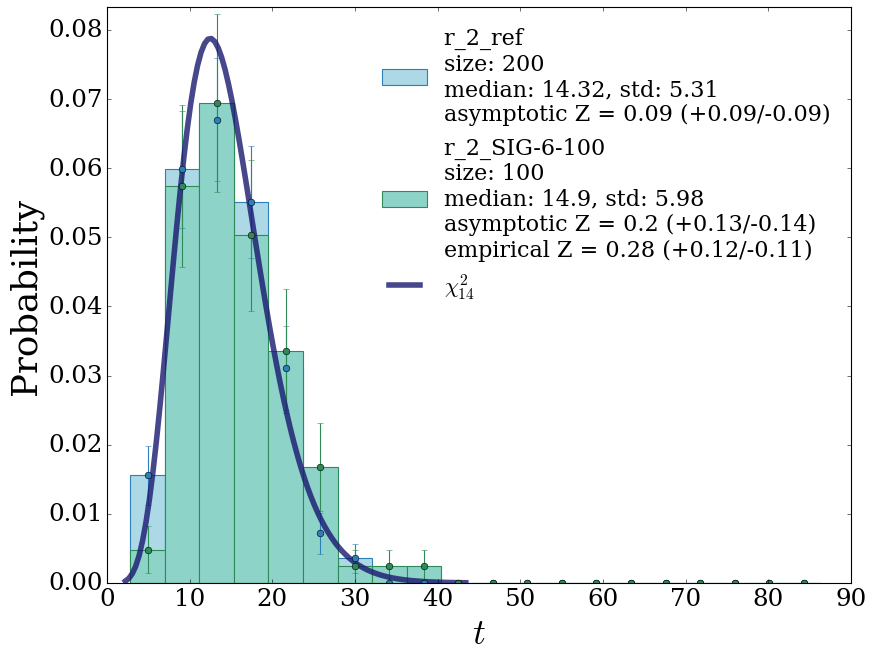

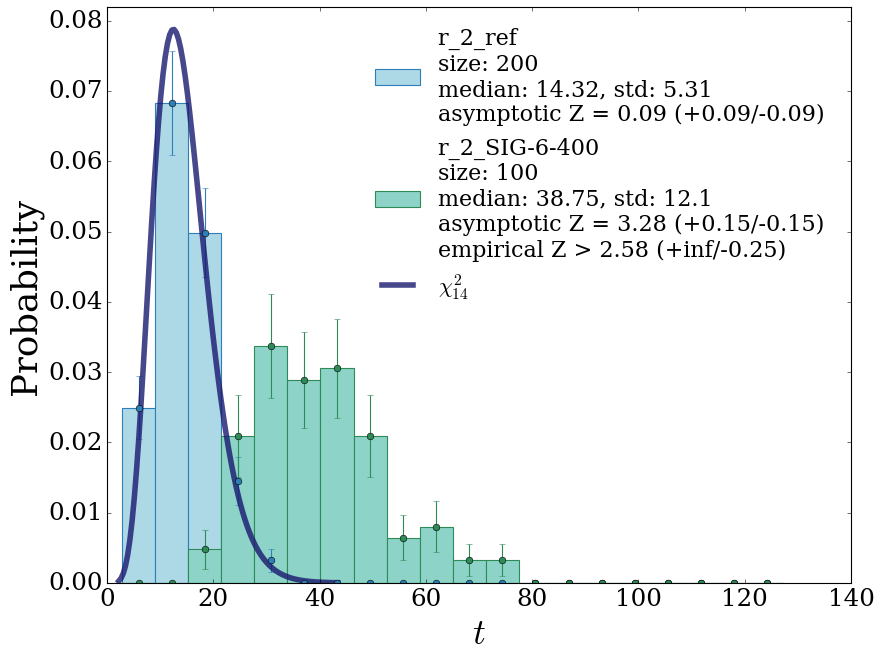

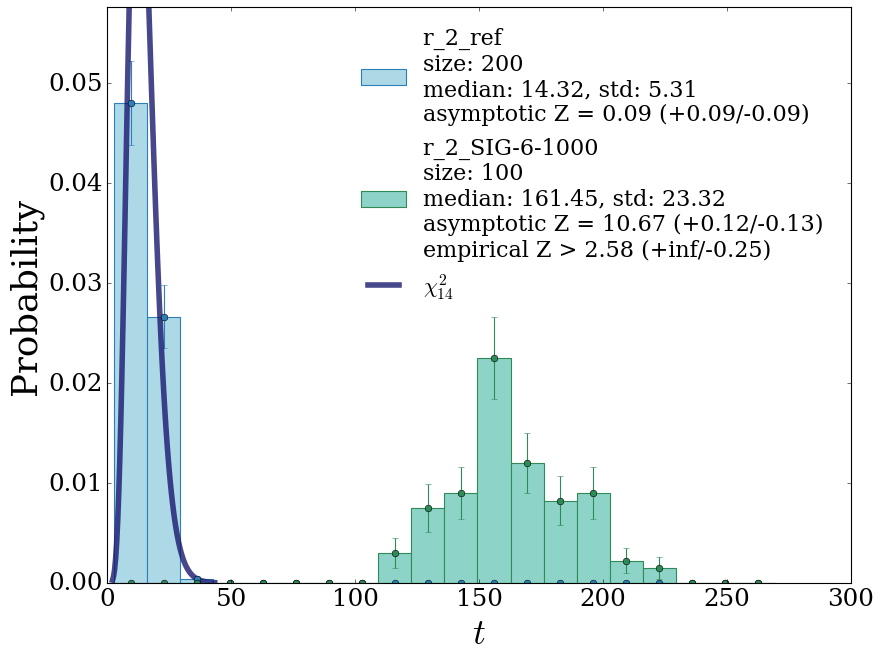

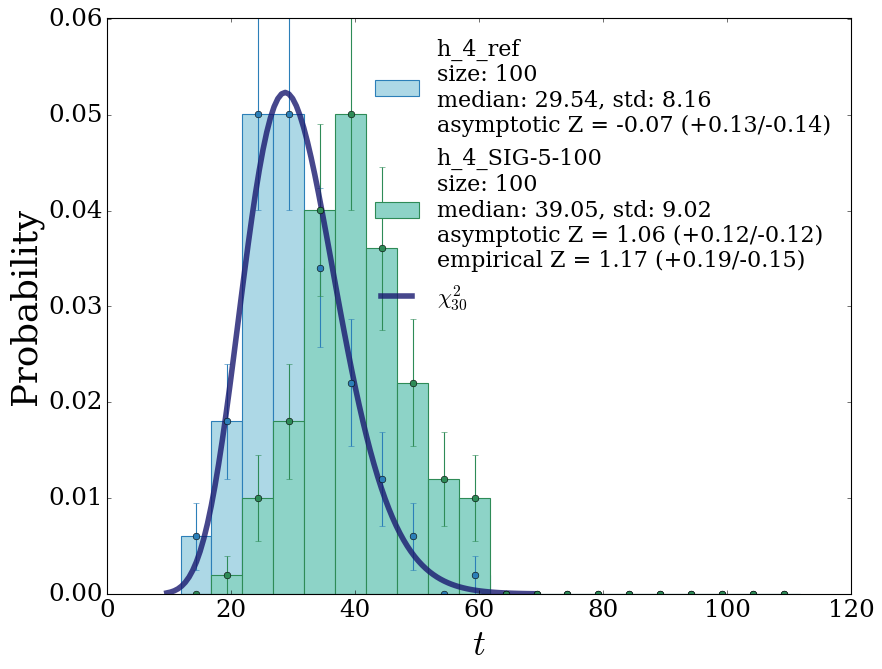

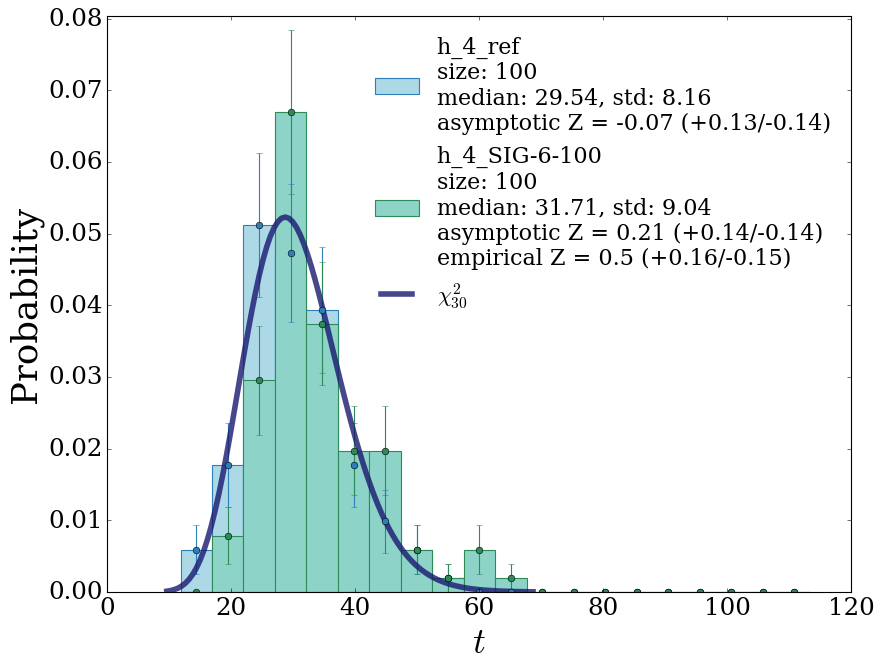

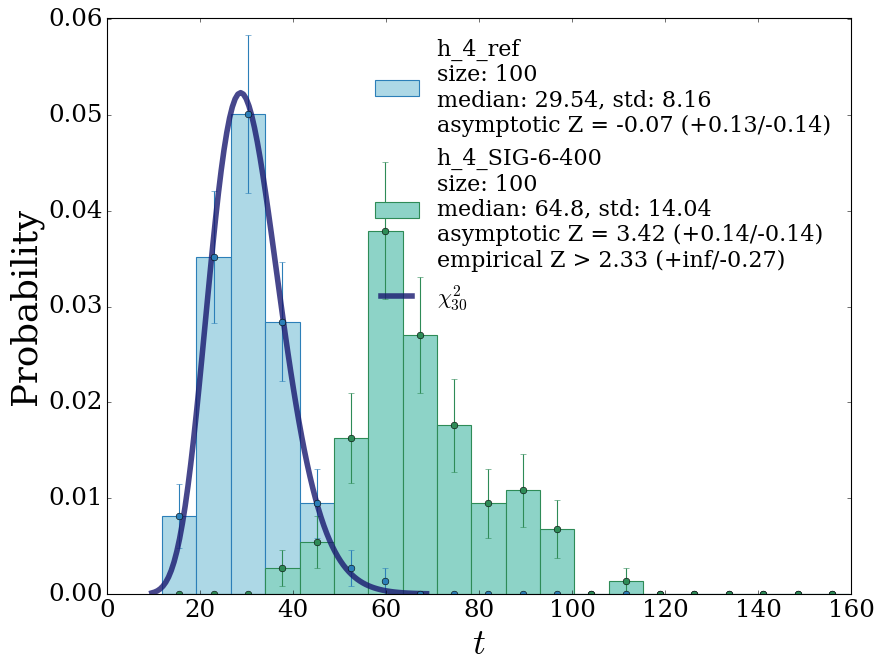

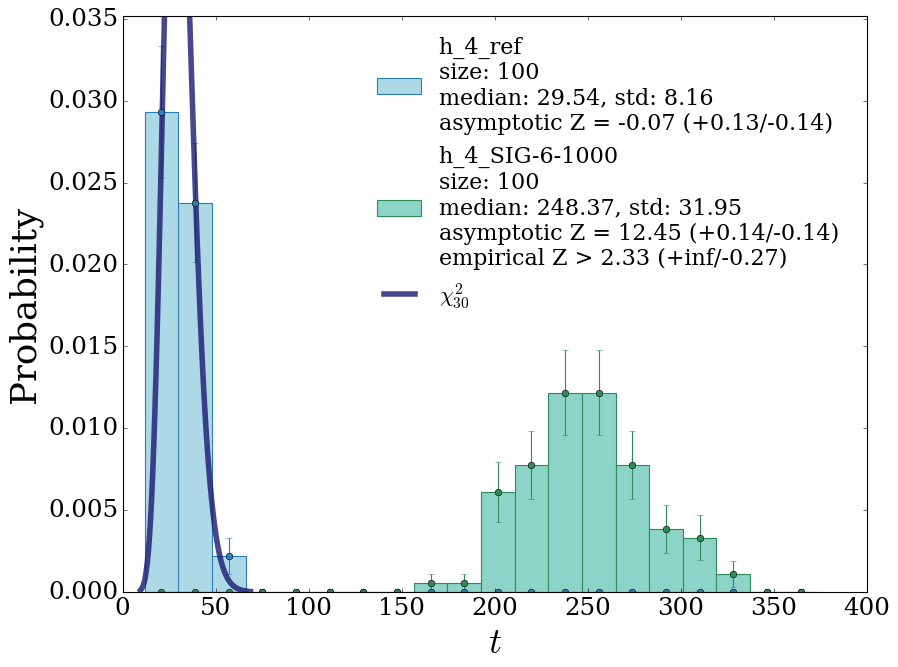

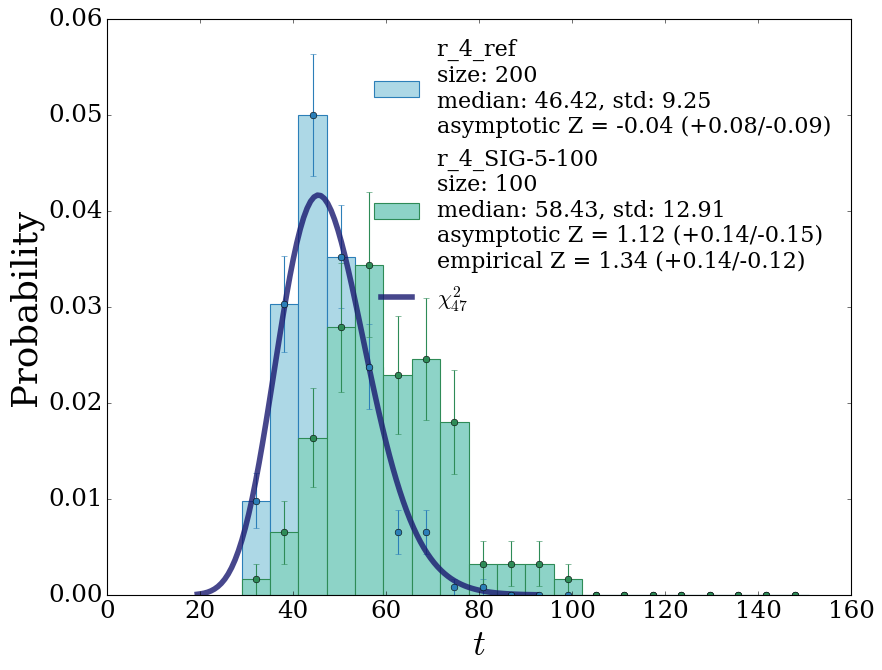

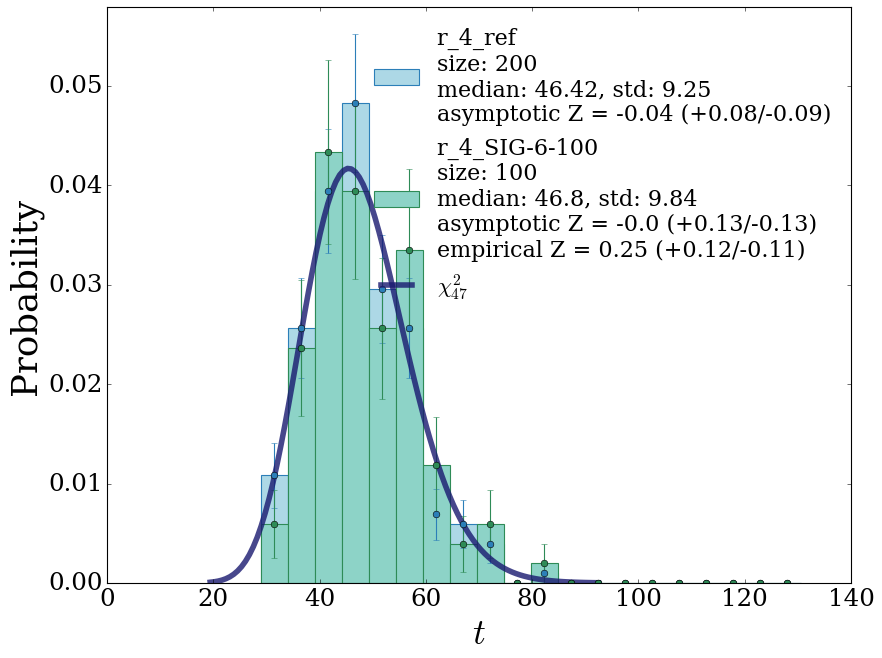

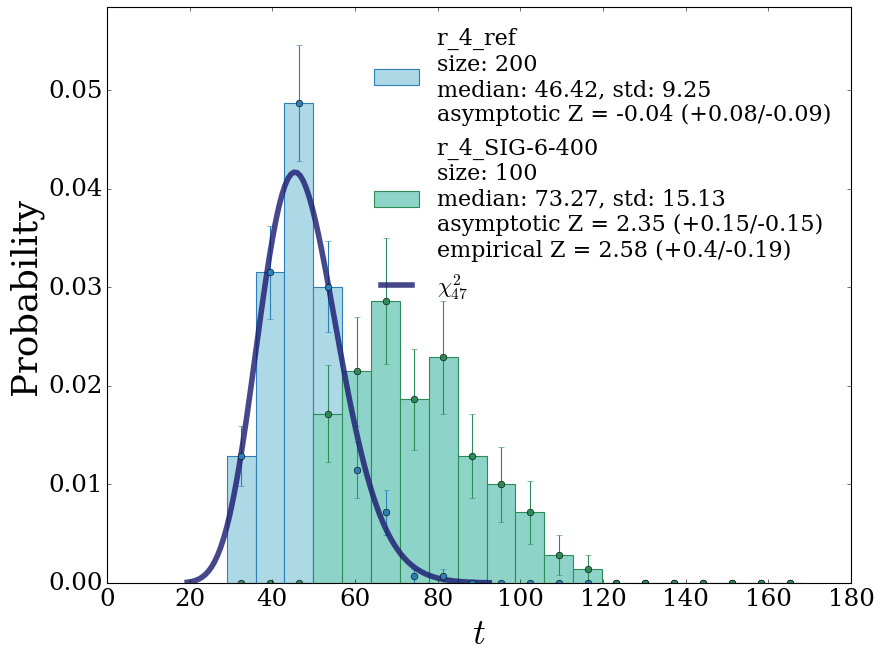

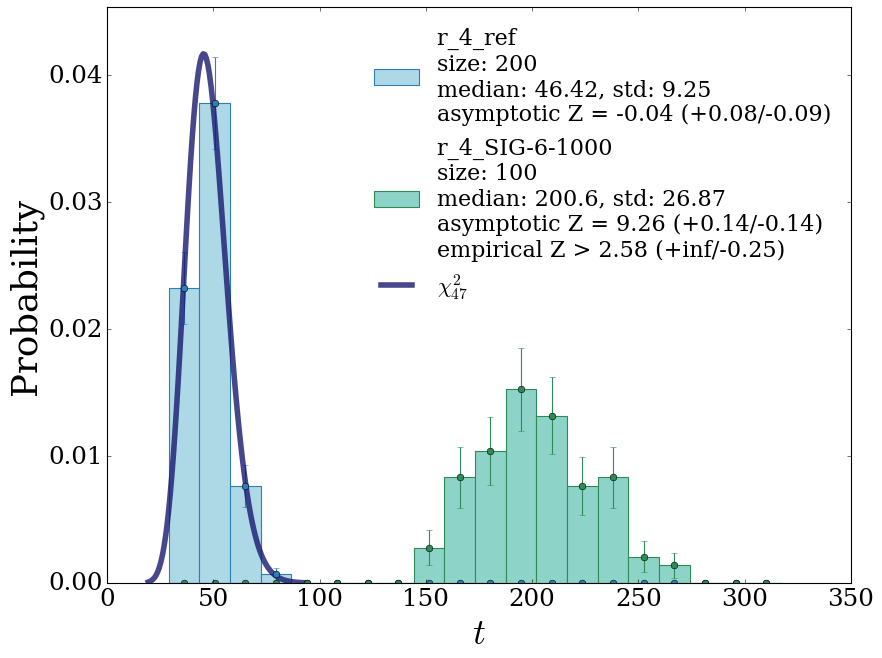

In [46]:

for key in list(tests.keys()):
    if 'ref' in key: continue
    key_ref = key.split('SIG')[0]+'ref'
    t1 = tests[key_ref]
    t2 = tests[key]
    df = np.mean(t1)
    xmax = np.max(t2)+50
    xmin = np.min(t1)
    plot_2distribution(t1, t2, df, xmin=xmin, xmax=xmax, ymax=None, nbins=20, 
                   save=False, output_path='', label1=key_ref, label2=key, save_name='', print_Zscore=True)
